In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader
import cv2

In [7]:
  def preprocess_input_img(test_image_path):
    '''
    This function takes the path to the input test image
    and returns a preprocessed image (which can be used as a input to the model)
    (Input): Single test image path
    (Output): Preprocessed image
    '''

    # Read the original test image
    orig_sample_test_img = cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB)

    # Convert image to gray scale
    gray_sample_test_img = cv2.cvtColor(orig_sample_test_img, cv2.COLOR_RGB2GRAY)

    # Resizing image to desired input size
    gray_resized_test_img = cv2.resize(gray_sample_test_img, (285, 285),
                        interpolation = cv2.INTER_AREA)   # To shrink an image

    # Remove blemishes from image (if any)
    (thresh, black_n_white_sample_img) = cv2.threshold(gray_resized_test_img, 70,255, cv2.THRESH_BINARY_INV)

    # Display Images	: Plot Sample Input and Preprocessed Test Image

#     f = plt.figure(figsize=(10,5))
#     ax1 = f.add_subplot(121)
#     ax2 = f.add_subplot(122)

#     ax1.imshow(np.squeeze(orig_sample_test_img), cmap='gray')
#     ax1.set_title("Original Test Input Image", pad=15, fontsize=13, fontweight='bold')
#     ax2.imshow(np.squeeze(black_n_white_sample_img), cmap='gray')
#     ax2.set_title("Preprocessed Test Input Image", pad=15, fontsize=13, fontweight='bold')
#     plt.tight_layout()
#     plt.show()

    return orig_sample_test_img, black_n_white_sample_img

def load_image(image_path, target_size=(285, 285)):
    _,img = preprocess_input_img(image_path)
    transform = transforms.Compose([
#         transforms.Resize(target_size),
        transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    img = transform(img)
    return img

In [3]:


# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, main_folder, target_size=(285, 285)):
        self.main_folder = main_folder
        self.target_size = target_size
        self.data = []

        for subdir, _, files in os.walk(main_folder):
            print(subdir,_)
            if 'image_data.csv' in files:
                csv_path = os.path.join(subdir, 'image_data.csv')
                df = pd.read_csv(csv_path)
                target_image_path = os.path.join(subdir, 'target.jpg')
                for _, row in df.iterrows():
                    X2_image_path = os.path.join(subdir, row['Image_Name'])
                    self.data.append((target_image_path, X2_image_path, row['x'], row['y']))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        target_image_path, X2_image_path, y1, y2 = self.data[idx]
        target_image = load_image(target_image_path, self.target_size)
        X2_image = load_image(X2_image_path, self.target_size)
        return (target_image, X2_image), torch.tensor([y1, y2], dtype=torch.float32)

# Initialize dataset and dataloaders
main_folder = './processed'  # Replace with your main folder path
dataset = CustomDataset(main_folder)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


./processed ['D8_1_2_3', 'D7_1_2', 'D8_1_2', 'D1', 'D8', 'D9_1_2', 'D9_1', 'D3_1', 'D4_1_2_3', 'D4_1', 'D4_1_2', 'D6_1_2', 'D3_1_2_3', 'D2_1_2', 'D4', 'D5_1_2', 'D9', 'D5_1_2_3', 'D3_2', 'D3', 'D2', 'D2_1', 'D8_1', 'D6_1', 'D5_1', 'D1_1', 'D7_1', 'D5', 'D1_1_2_3', 'D2_1_2_3', 'D3_1_2', 'D7', 'D9_1_2_3', 'D6', 'D7_1_2_3', 'D1_1_2', 'D6_1_2_3']
./processed/D8_1_2_3 []
./processed/D7_1_2 []
./processed/D8_1_2 []
./processed/D1 []
./processed/D8 []
./processed/D9_1_2 []
./processed/D9_1 []
./processed/D3_1 []
./processed/D4_1_2_3 []
./processed/D4_1 []
./processed/D4_1_2 []
./processed/D6_1_2 []
./processed/D3_1_2_3 []
./processed/D2_1_2 []
./processed/D4 []
./processed/D5_1_2 []
./processed/D9 []
./processed/D5_1_2_3 []
./processed/D3_2 []
./processed/D3 []
./processed/D2 []
./processed/D2_1 []
./processed/D8_1 []
./processed/D6_1 []
./processed/D5_1 []
./processed/D1_1 []
./processed/D7_1 []
./processed/D5 []
./processed/D1_1_2_3 []
./processed/D2_1_2_3 []
./processed/D3_1_2 []
./process

In [3]:
import torch
import torch.nn as nn
from torchvision import models

class CustomResNet(nn.Module):
    def __init__(self, num_outputs=6):
        super(CustomResNet, self).__init__()

        
        
        
        self.vgg = models.vgg16(pretrained=False)
#         num_ftrs = self.vgg.fc.in_features
        self.vgg.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        n_inputs = self.vgg.classifier[0].in_features
#         self.ff=self.vgg.classifier
#         self.vgg.avgpool=nn.Identity()
        self.vgg.classifier = nn.Identity()  # Remove the last fully connected layer

        
        
        # # Additional layers for combined features
#         self.fc0=nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
#         self.a = nn.AdaptiveAvgPool2d(output_size=(1, 7))
#         self.cf= nn.Sequentio
    
       
#         self.ff[6]= nn.Sequential(nn.Linear(n_inputs, 512),nn.ReLU(),nn.Linear(512,256),nn.ReLU(),nn.Linear(256, 128),
#                                 nn.ReLU(),  nn.Linear(128, 64),nn.ReLU(),nn.Linear(64, 2)
# #                                   ,  nn.Dropout(0.4),
# #                                   nn.Linear(8, 2) 
#                                  )

        self.fc1 = nn.Linear(n_inputs*2 , 512)
        self.fc11= nn.Linear(512,256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fcd=nn.Dropout(0.2)
        self.fc5 = nn.Linear(32, 8)
        self.fc6 = nn.Linear(8, 2)

        self.tanh = nn.Tanh()

    def forward(self, x1, x2):
        # Extract features from both images
        f1 = self.vgg(x1)
        f2 = self.vgg(x2)
#         print(f1.shape)
#         print(f2.shape)

        # Concatenate features
        combined = torch.cat((f1, f2), dim=1)
#         combined = self.vgg(combined)
#         x= self.ff(combined)
#         x = self.tanh(x)
        # Fully connected layers
        
        x = nn.ReLU()(self.fc1(combined))
        x = nn.ReLU()(self.fc11(x))

        x = nn.ReLU()(self.fc2(x))
        x = nn.ReLU()(self.fc3(x))
        x = nn.Tanh()(self.fc4(x))
        x = nn.Tanh()(self.fc5(x))
#         x = nn.Tanh()(self.fc6(x)) 
        x = self.tanh(self.fc6(x))

        return x

# Initialize the model
model = CustomResNet()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


CustomResNet(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Loss [1, 120](epoch, minibatch):  0.7530479964613914
Epoch [1/30], Train Loss: 0.0283, Validation Loss: 0.6052, Train MAE: 0.6414, Validation MAE: 0.6138
Loss [2, 120](epoch, minibatch):  0.741862713098526
Epoch [2/30], Train Loss: 0.0293, Validation Loss: 0.6199, Train MAE: 0.6259, Validation MAE: 0.6288
Loss [3, 120](epoch, minibatch):  0.7455597990751266
Epoch [3/30], Train Loss: 0.0262, Validation Loss: 0.6047, Train MAE: 0.6218, Validation MAE: 0.6105
Loss [4, 120](epoch, minibatch):  0.7427587595582008
Epoch [4/30], Train Loss: 0.0282, Validation Loss: 0.6057, Train MAE: 0.6183, Validation MAE: 0.6090
Loss [5, 120](epoch, minibatch):  0.7403184860944748
Epoch [5/30], Train Loss: 0.0304, Validation Loss: 0.6033, Train MAE: 0.6187, Validation MAE: 0.6120
Loss [6, 120](epoch, minibatch):  0.7418143326044082
Epoch [6/30], Train Loss: 0.0288, Validation Loss: 0.6059, Train MAE: 0.6185, Validation MAE: 0.6198
Loss [7, 120](epoch, minibatch):  0.741156495809555
Epoch [7/30], Train Loss:

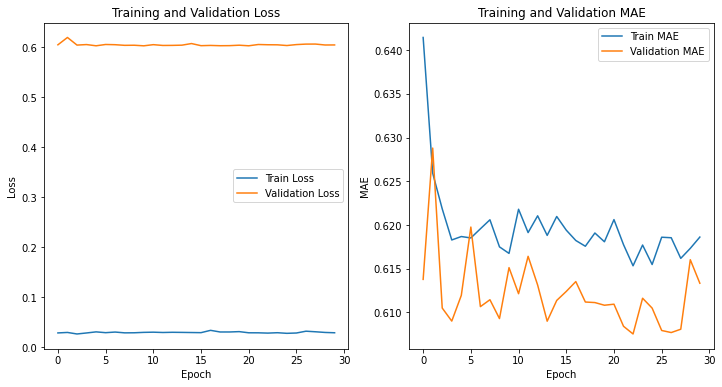

In [17]:
import matplotlib.pyplot as plt

# Initialize lists to store losses and MAE
train_losses = []
val_losses = []
train_maes = []
val_maes = []

# Define MAE criterion
mae_criterion = nn.L1Loss()

# Training loop
EPOCHS = 30
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    running_mae = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        (target_images, X2_images), labels = inputs, labels
        target_images, X2_images, labels = target_images.to(device), X2_images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(target_images, X2_images)
        loss = criterion(outputs, labels)
        mae = mae_criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_mae += mae.item()
        
#         if i % 120 == 0 and i > 0:
#             print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', running_loss / 100)
#             running_loss = 0.0

    # Store the training loss and MAE
    train_losses.append(running_loss / len(train_loader))
    train_maes.append(running_mae / len(train_loader))

    # Validation step
    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    with torch.no_grad():
        for data in val_loader:
            (target_images, X2_images), labels = data
            target_images, X2_images, labels = target_images.to(device), X2_images.to(device), labels.to(device)
            outputs = model(target_images, X2_images)
            loss = criterion(outputs, labels)
            mae = mae_criterion(outputs, labels)
            val_loss += loss.item()
            val_mae += mae.item()
    
    val_losses.append(val_loss / len(val_loader))
    val_maes.append(val_mae / len(val_loader))
    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Train MAE: {train_maes[-1]:.4f}, Validation MAE: {val_maes[-1]:.4f}')

print('Training Done')

# Plot the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Training and Validation MAE')

plt.show()


In [ ]:
# net = ResNet50(10).to('cuda')
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [ ]:
# EPOCHS = 30
# for epoch in range(EPOCHS):
#     model.train()
#     running_loss = 0.0
#     for i, (inputs, labels) in enumerate(train_loader):
#         (target_images, X2_images), labels = inputs, labels
#         target_images, X2_images, labels = target_images.to(device), X2_images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(target_images, X2_images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
        
#         if i % 10 == 0 and i > 0:
#             print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', running_loss / 100)
#             running_loss = 0.0

# print('Training Done')

# # Validation loop
# model.eval()
# correct = 0
# total = 0

# with torch.no_grad():
#     for data in val_loader:
#         (target_images, X2_images), labels = data
#         target_images, X2_images, labels = target_images.to(device), X2_images.to(device), labels.to(device)
#         outputs = model(target_images, X2_images)

#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print('Accuracy on validation dataset: ', 100 * (correct / total), '%')

In [ ]:

total_loss = 0

with torch.no_grad():
    for data in val_loader:
        (target_images, X2_images), labels = data
        target_images, X2_images, labels = target_images.to(device), X2_images.to(device), labels.to(device)
        outputs = model(target_images, X2_images)

        loss = criterion(outputs, labels)
        total_loss += loss.item()
#         correct += (predicted == labels).sum().item()

avg_loss = total_loss / len(val_loader)
print('Validation Loss: ', avg_loss)


In [5]:
import torch
from PIL import Image
import torchvision.transforms as transforms

# Define the image preprocessing steps
transform = transforms.Compose([
    transforms.Resize((285, 285)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Function to load and preprocess a single image
def load_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = transform(img)
    return img.unsqueeze(0)  # Add batch dimension

# Paths to the target image and the test image
target_image_path =  './processed/D2/target.jpg'
test_image_path = './processed/D2/img001.jpg'


# Load and preprocess the images
target_image = load_image(target_image_path).to(device)
test_image = load_image(test_image_path).to(device)

# Set the model to evaluation mode
model.eval()

# Disable gradient calculation
with torch.no_grad():
    # Get the model's output
    output = model(target_image, test_image)

# Print the output
print('Model Output:', output)


RuntimeError: Given groups=1, weight of size [64, 1, 3, 3], expected input[1, 3, 285, 285] to have 1 channels, but got 3 channels instead